# Hulpprogramma "dode tijd compenstatie"
Compenstatie is noodzakelijk wanneer dode tijd een significant deel uitmaakt van een proces. Verschillend onderzoek geeft een verscheidenheid aan informatie en procedures wat het praktisch opstellen van een regelaar bemoeilijkt. We maken de brug van theorie naar praktijk door de tabellen en ontwerpstappen om te vormen in een script. Wat het PID design gemakkelijker maakt en tijd bespaart.

## Handleiding
* Elke blok kan je 'runnen' met CRTL+ENTER. 
* Elke blok vervult een functie welke staat beschreven in de notities

## Volgorde
* Keuze van procesmodel
* Ingeven van parameters
* Creatie van regelaar(s)
* Visualisatie

In [1]:
#Import libraries

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

import control as c
from control.matlab import * 

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math
import ipywidgets as widgets
from widget_functions import *

import webbrowser
sysidlink = "https://keen-leavitt-dde150.netlify.app/guide/03_systeem_theorie/#identificatie"



In [2]:
# Widget input

plantchoice = widgets.RadioButtons(
    options=['FOPTD','PTD','IPTD','IFOPTD','DIPTD', 'geen idee'],
    description='soorten procesmodellen: ',
    disable=False
    )

sys_response = widgets.RadioButtons(
    options=['Stapantwoord','Setpoint-tracking','Sensitiviteit verstoring','Algemene prestaties'],
    description='Plot prestatie',
    disable=False
    )

# Functions
 
def instructions(plantchoice):
    """Deze functie bekijkt het gekozen model en start het daarbijhorend stappenplan op."""
    if plantchoice.value == 'geen idee':
        webbrowser.open(sysidlink,new=0)
    elif plantchoice.value == 'FOPTD':
        azamfar_markazi_foptd()
    elif plantchoice.value == 'PTD':
        print("Let op: tau = 1")
        azamfar_markazi_foptd()
    elif plantchoice.value == 'IPTD':
        azamfar_markazi_iptd()
    else:
        print('Nog geen code')
        
############## azamfar_markazi formulae ###########
def azamfar_markazi_foptd():
    """Berekend voor een FOPTD (eerste orde pure dode tijd) de daarbijhorende
    regelaars en bouwt het systeem (sys) in een transferfunctie structuur.
    De transferfuncties worden globaal overschreven."""
    # Global declaratie
    global C
    global G
    global T
    global Gtilde
    global sys
    global sys_ref
    # Input
    print("Je hebt een FOPTD model. Haal uit het model de volgende waardes.")
    k = float(input("De k-waarde is: "))
    tau = float(input("Tau (de tijdsconstante) is: "))
    theta = float(input("De vertraging (seconden) is: "))
    beta = float(input("Kies een beta-waarde: "))
    # Parameters
    alpha = 0.4 
    # Tabelparameters
    k_p = alpha * (theta + beta)
    k_d = 0.724 / (k * (theta + beta))
    lamb = 0.04 * (theta + beta) 
                  
    # bereken het proces
    G = ontw_proces(k, 0, 1, tau, 0, theta)
    G_ = ontw_proces(k, 0, 1, tau, 0, 0)    #zonder dode tijd
    print("Het procesmodel: ", G_)
    # bereken de PID regelaar (C) adhv specifieke vergelijking
    s = c.tf('s')
    C = k_d * (1 / (beta*s + 1)) * ((tau*s + 1) / (s*(lamb*s + 1)))
    print("De controller C(s): ", C)
    # bereken de interne regelaar (T) adhv specifieke vergelijking
    T = 0 # in het geval van FOPTD
    # bereken de FF regelaar (Gtilde) adhv specifieke vergelijking
    Gtilde = k_p * ((k * s) / (tau*s + 1))
    Gdelay = c.pade(theta,10)
    dnum = Gdelay[0]
    dden = Gdelay[1]
    Gdelay = c.tf(dnum,dden)
    Gtilde = c.series(Gtilde,Gdelay)

    # maak de regellus
    sys_ref = build_controlstructure_fb(C,G)
    sys = build_controlstructure_azamfar_markazi(C, G, T, Gtilde)
    print("Het systeem 'sys' werd gegenereerd en is klaar voor gebruik!")
    
                  
def azamfar_markazi_iptd():
    """Berekend voor een IPTD (integraal pure dode tijd) de daarbijhorende
    regelaars en bouwt het systeem (sys) in een transferfunctie structuur.
    De transferfuncties worden globaal overschreven."""
    # Global declaratie
    global C
    global G
    global T
    global Gtilde
    global sys
    global sys_ref
    # Input
    print("Je hebt een IPTD model. Haal uit het model de volgende waardes.")
    k = float(input("De k-waarde is: "))
    theta = float(input("De vertraging (seconden) is: "))
    beta = float(input("Kies een beta-waarde: "))
    # Parameters
    alpha = 0.4 
    # Tabelparameters
    k_p = alpha * (theta + beta)
    k_i = 0.5236 / (k * theta)
    k_d = 0.724 / (k * (theta + beta))
    lamb = 0.04 * (theta + beta) 
                  
    # bereken het proces
    G = ontw_proces(k, 0, 0, 1, 0, theta)
    G = ontw_proces(k, 0, 0, 1, 0, 0)
    print("Het procesmodel: ", G_)
    # bereken de dode tijd
    Gdelay = c.pade(theta,10)
    dnum = Gdelay[0]
    dden = Gdelay[1]
    Gdelay = c.tf(dnum,dden)
    # bereken de PID regelaar (C) adhv specifieke vergelijking
    s = c.tf('s')
    C = k_d * (1 / (beta*s + 1)) * (1 + ((0.5236 / (theta*s + 1))*Gdelay) / (lamb*s + 1))
    print("De controller C(s): ", C)
    # bereken de interne regelaar (T) adhv specifieke vergelijking
    T = k_i 
    # bereken de FF regelaar (Gtilde) adhv specifieke vergelijking
    Gtilde = k_p * k * ((Gdelay) / (1 + (0.5236/(theta*s))*Gdelay))

    # maak de regellus
    sys_ref = build_controlstructure_fb(C,G)
    sys = build_controlstructure_azamfar_markazi(C, G, T, Gtilde)
    print("Het systeem 'sys' werd gegenereerd en is klaar voor gebruik!")
    
def build_controlstructure_fb(C,G):
    CG = c.series(C,G)
    sys_ref = c.feedback(CG,1,sign=-1)
    return sys_ref

def build_controlstructure_azamfar_markazi(C, G, T, Gtilde):
    """Combines calculated C, G, T and Gtilde and makes the full control system 
    specified in "Simple Formulae for control of industrial time delay systems"
    writen by Moslem Azamfar and Amir H. D. Markazi"""
    global sys
    GT_fb = c.feedback(G,T,sign=-1)
    CGT_fb = c.series(C,GT_fb)
    Gtilde_frac = Gtilde / GT_fb
    sys = c.feedback(CGT_fb,Gtilde_frac,sign=-1)
    sys = c.feedback(sys,1,sign=-1)   
    return sys

############## plot system performance ###########
def plot_prest(sys_response):
    """Deze functie leest de gevraagde visualisatie en geeft deze weer."""
    if sys_response.value == 'Stapantwoord':
#         sys_step()
        tsys, ysys = c.step_response(sys)
        tG, yG = c.step_response(sys_ref)
        plt.plot(tsys,ysys)
        plt.plot(tG, yG)
        stop = 20
        plt.xlim([0,stop])
        # plt.ylim([0,max(y)])
        plt.title('Stapantwoord')
        plt.legend(['controlled system','uncontrolled system'])
    elif sys_response.value == 'Setpoint-tracking':
#         sys_step_custom()
        dt = 1
        stop = 200
        T = np.arange(0,stop,dt)
        step_init = 20
        step_size = 50
        U = step_init*np.ones(stop)
        section = int(stop/2)
        for i in range(section):
            U[-i-1] = step_init + step_size
    #         section = int(stop/4)
    #         for i in range(section):
    #             U[-i-1] = 0
        t, y = c.forced_response(sys,T,U)
        tG, yG = c.forced_response(sys_ref,T,U)

        plt.plot(U)
        plt.plot(y)
        plt.plot(yG)
        plt.xlim([0,stop])
        plt.ylim([0,(step_init+step_size)*1.5])
        plt.xlabel('time[s]')
        plt.ylabel('amplitude')
        plt.title('Setpoint-tracking')
        plt.legend(['input', 'output_controlled','output_uncontrolled']) 
    elif sys_response.value == 'Sensitiviteit verstoring':
#         sys_dist_resp()
        dt = 1
        stop = 10
        T = np.arange(0,stop,dt)
        U = np.sin(10*T+1.2)   #distrubance rejection
        t, y = c.forced_response(sys,T,U)
        tG, yG = c.forced_response(sys_ref,T,U)
        plt.plot(U)
        plt.plot(y)
        plt.plot(yG)
        plt.xlim([0,stop])
        plt.xlabel('time[s]')
        plt.ylabel('amplitude')
        plt.title('distrubance rejection')
        plt.legend(['input', 'output_controlled','output_uncontrolled']) 
    elif sys_response.value == 'Algemene prestaties': 
#         sys_perf()
        gm, pm, wg, wp = margin(sys)
        print("De versterkingsmarge (GM) is: ", gm)
        print("De fasemarge (PM) is: ", pm)
        print("De frequentie op de frequentie-crossover (-180°) is: ", gm)
        print("De frequentie op de versterkingsmarge (-1) is: ", pm)              
        plt.figure(10)
        c.gangof4_plot(C,G)
        plt.figure(20)
        c.bode_plot(sys)
        plt.figure(30)
        c.nyquist_plot(sys)
        plt.figure(40)
        c.nichols_plot(sys)
    else:
        print("Er is hier niets")

# def sys_step():
    
    
# def sys_step_custom():
  

# def sys_dist_resp():
    

# def sys_perf():
           

![control_smith_adv.jpg](./images/control_smith_adv.jpg)

In [3]:
# Kies het soort procesmodel die je uit de systeemidentificatie haalde.
plantchoice

RadioButtons(description='soorten procesmodellen: ', options=('FOPTD', 'PTD', 'IPTD', 'IFOPTD', 'DIPTD', 'geen…

In [4]:
instructions(plantchoice)

Je hebt een FOPTD model. Haal uit het model de volgende waardes.
De k-waarde is: 5
Tau (de tijdsconstante) is: 1000
De vertraging (seconden) is: 1
Kies een beta-waarde: 0.1
Het procesmodel:  
    5
----------
1000 s + 1

De controller C(s):  
     131.6 s + 0.1316
--------------------------
0.0044 s^3 + 0.144 s^2 + s

Het systeem 'sys' werd gegenereerd en is klaar voor gebruik!


In [10]:
sys_response

RadioButtons(description='Plot prestatie', index=1, options=('Stapantwoord', 'Setpoint-tracking', 'Sensitivite…

In [11]:
sys_response.value

'Setpoint-tracking'

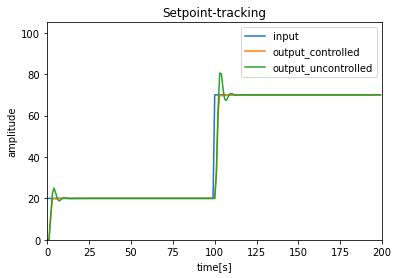

In [12]:
plot_prest(sys_response)

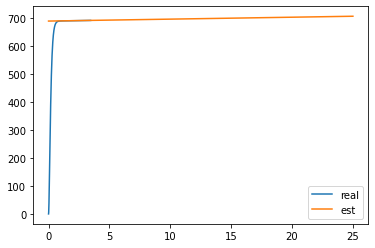

In [28]:
t, y = c.step_response(C)
tt, yy = c.step_response(c.tf([689.5, 0.6895],[1, 0]))
plt.plot(t,y)
plt.plot(tt,yy)
plt.legend(['real','est'])

In [30]:
# Calculate Kp, Ki and Kd for a resulting controller C
C.num
C.den


[[array([689.52380952,   0.68952381])]]